## <u>*Classsification Modelling for gender as a Target Feature*</u>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os
import json

In [22]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK,Trials
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

---

*Importing Data :*

In [4]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/data_car.csv")
df=df.drop(["X_OBSTAT_","clm","numclaims"],axis=1)
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0.0,UTE,2,F,E,2
3,4.14,0.317591,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0.0,HBACK,4,F,C,2


---

*Sorting Data :*

In [5]:
df=df.sort_values(by=['veh_age', 'agecat','area','gender']).reset_index().drop("index",axis=1)
df.head()

,veh_value,exposure,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.59,0.229979,0.0,SEDAN,1,F,A,1
1,1.46,0.221766,0.0,HBACK,1,F,A,1
2,1.54,0.238193,0.0,SEDAN,1,F,A,1
3,1.57,0.522930,0.0,SEDAN,1,F,A,1
4,1.41,0.219028,0.0,HBACK,1,F,A,1


---

*Data Shape :*

In [6]:
df.shape

(67856, 8)

---

*Define categorical features and numerical features :*

In [7]:
categorical_features=df.select_dtypes(include=["object"])
numerical_features=df.select_dtypes(exclude=["object"])

print("we have {} numerical features : {}\n".format(numerical_features.shape[1],list(numerical_features.columns)))
print("we have {} categorical features : {}".format(categorical_features.shape[1],list(categorical_features.columns)))

we have 3 numerical features : ['veh_value', 'exposure', 'claimcst0']

we have 5 categorical features : ['veh_body', 'veh_age', 'gender', 'area', 'agecat']


---

*Categorical features Frequency percenatge :*

In [8]:
for col in categorical_features:
    print(df[col].value_counts(normalize=True)*100)

veh_body
SEDAN    32.764973
HBACK    27.875206
STNWG    23.963983
UTE       6.758430
TRUCK     2.578991
HDTOP     2.326987
COUPE     1.149493
PANVN     1.108229
MIBUS     1.056649
MCARA     0.187161
CONVT     0.119370
BUS       0.070738
RDSTR     0.039790
Name: proportion, dtype: float64
veh_age
3    29.568498
4    27.923839
2    24.444412
1    18.063252
Name: proportion, dtype: float64
gender
F    56.88959
M    43.11041
Name: proportion, dtype: float64
area
C    30.269983
A    24.039142
B    19.660752
D    12.044624
E     8.712568
F     5.272931
Name: proportion, dtype: float64
agecat
4    23.857876
3    23.235970
2    18.974004
5    15.821740
6     9.648373
1     8.462037
Name: proportion, dtype: float64


---

*Visualizing numerical features :*

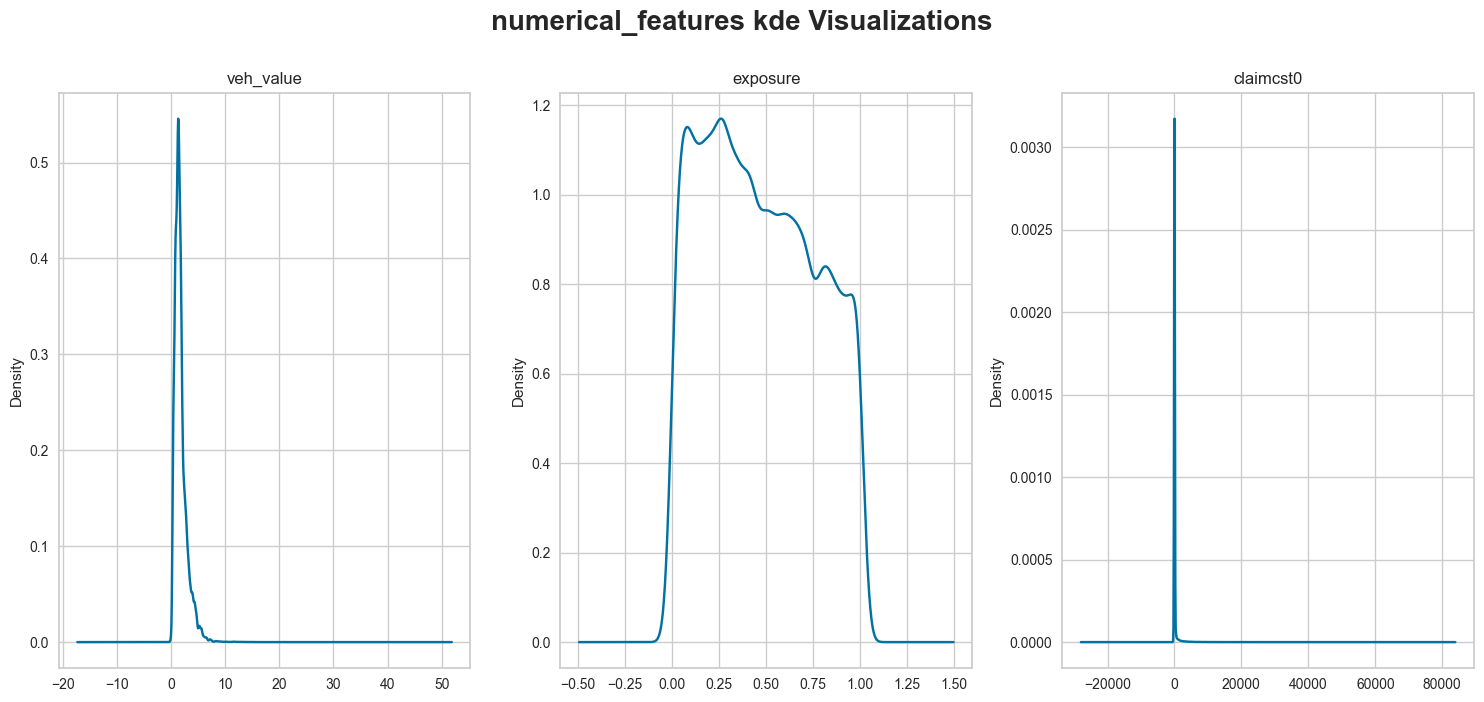

In [31]:
def plot_numerical_features(numerical_features,ChartType):
    
    nrows = 1
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7))
    fig.suptitle(f"numerical_features {ChartType} Visualizations",fontsize=20,fontweight="bold",y=1.)
    
    axes = axes.flatten()

    for i, column in enumerate(numerical_features.columns):
        if i >= nrows * ncols:
            break 
        numerical_features[column].plot(ax=axes[i], kind=f"{ChartType}",title=column)
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_numerical_features.png',dpi=500);
        


    plt.tight_layout()
    plt.show();

plot_numerical_features(numerical_features[["veh_value","exposure","claimcst0"]],"kde");


---

*Visualizing categorical features :*

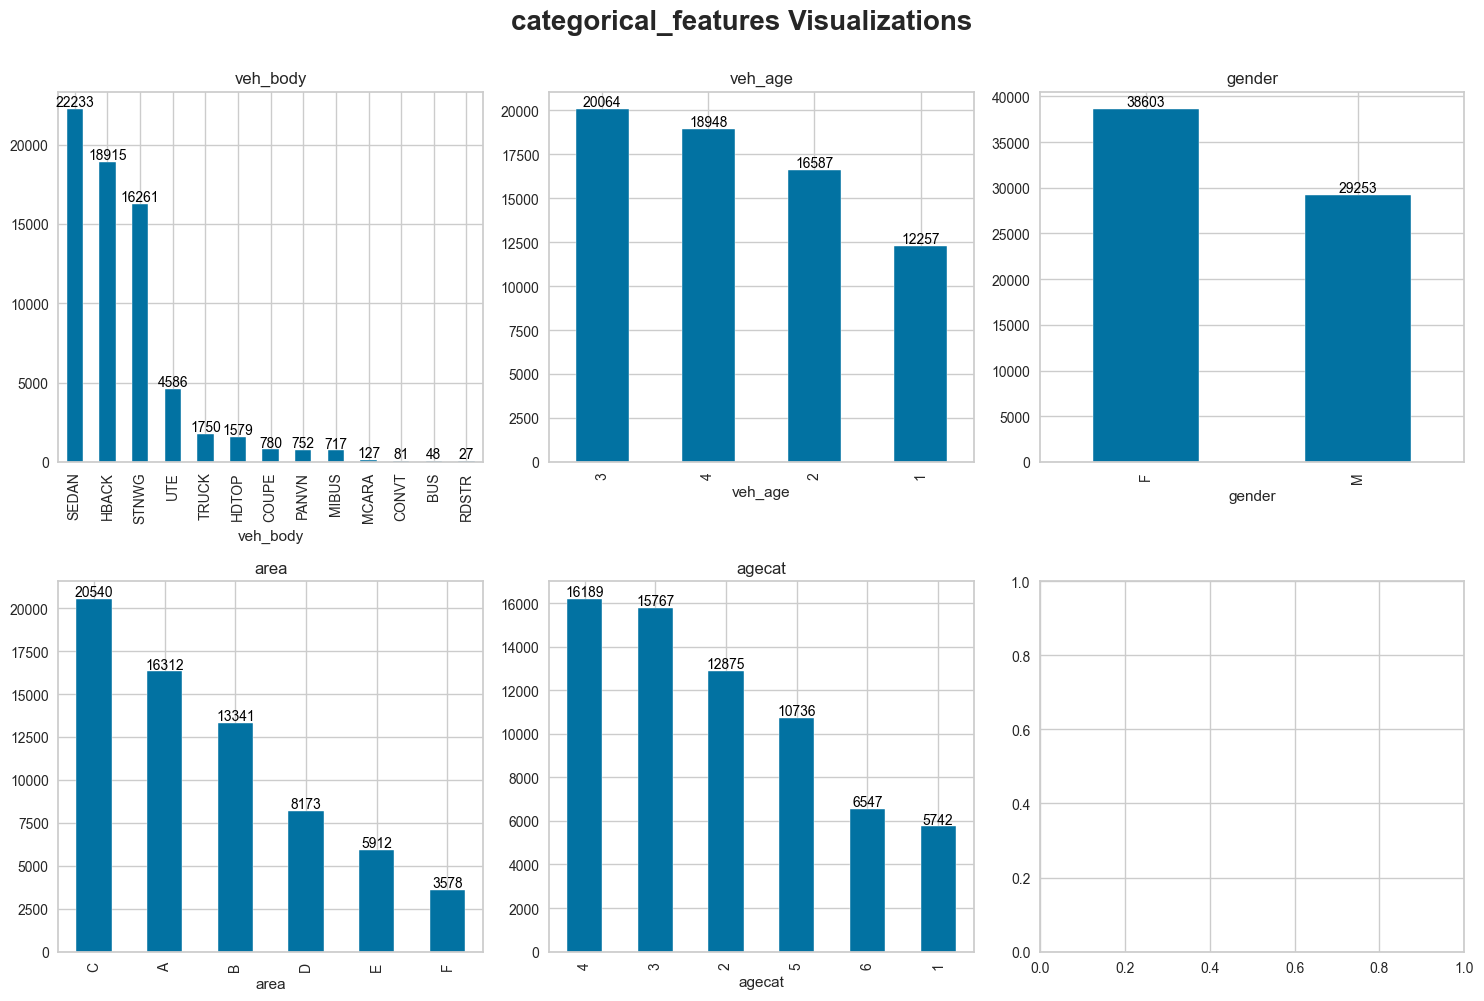

In [21]:
def plot_categorical_features(categorical_features):
    nrows = 2
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    fig.suptitle(f"categorical_features Visualizations",fontsize=20,fontweight="bold",y=1.)

    axes = axes.flatten()
    
    for i, column in enumerate(categorical_features.columns):
        if i >= nrows * ncols:
            break 
        ax = axes[i]
        counts = categorical_features[column].value_counts()
        counts.plot(kind='bar', ax=ax, title=column)
        
        for bar in ax.patches:
            ax.annotate(
                str(bar.get_height()),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points'
            )
        plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/generalGraphs/plot_categorical_features.png',dpi=500);
        
    plt.tight_layout()
    plt.show()

plot_categorical_features(categorical_features)    

---

*Define discretes feature and countinuous features :*

In [9]:
discrete_feature=[feature for feature in numerical_features if  len(df[feature].unique())<=25]
countinuous_feature=[feature for feature in numerical_features if  len(df[feature].unique())>25]

In [10]:

print("we have {} discrete feature : {}\n".format(len(discrete_feature),(discrete_feature)))
print("we have {} countinuous feature : {}".format(len(countinuous_feature),(countinuous_feature)))

we have 0 discrete feature : []

we have 3 countinuous feature : ['veh_value', 'exposure', 'claimcst0']


---

*Categorical features Frequency percenatge by gender :*

In [11]:
(df.groupby("area")["gender"].value_counts(normalize=True).to_frame()*100).T

area                A                     B                     C             \
gender              F          M          F          M          F          M   
proportion  56.921285  43.078715  57.274567  42.725433  57.512171  42.487829   

area                D                     E                     F             
gender              F          M          F          M          F          M  
proportion  57.959134  42.040866  55.328146  44.671854  51.872554  48.127446

* *Insights :*

*1. Females Proportions are more than males in all areas*

*2. Area F has the lowest Proportion variance between genders*

---

In [12]:
(df.groupby("agecat")["gender"].value_counts(normalize=True).to_frame()*100).T

agecat             1                   2                    3             \
gender             F         M         F         M          F          M   
proportion  57.01846  42.98154  59.12233  40.87767  59.104459  40.895541   

agecat              4                     5                     6             
gender              F          M          F          M          M          F  
proportion  57.928223  42.071777  53.735097  46.264903  50.343669  49.656331

* *Insights :*

*1. Females Proportions are more than males among all age categories except for age category 6*

*2. In age category 6 where the Proportion of males more than females the Proportion variance is the lowest between genders*

---

In [13]:
(df.groupby("veh_age")["gender"].value_counts(normalize=True).to_frame()*100).T

veh_age            1                    2                     3             \
gender             F         M          F          M          F          M   
proportion  58.29322  41.70678  59.896304  40.103696  58.348285  41.651715   

veh_age            4            
gender             F         M  
proportion  51.80494  48.19506

* *Insights :*

*1. Females Proportions are more than males among all veh ages*

*2. veh age 4 has the lowest Proportion variance between genders*

In [14]:
(df.groupby("veh_body")["gender"].value_counts(normalize=True).to_frame()*100).T

veh_body          BUS                 CONVT                 COUPE             \
gender              M          F          F          M          F          M   
proportion  66.666667  33.333333  62.962963  37.037037  53.205128  46.794872   

veh_body        HBACK                 HDTOP             ...     RDSTR  \
gender              F          M          M          F  ...         M   
proportion  70.483743  29.516257  54.971501  45.028499  ...  70.37037   

veh_body                 SEDAN                STNWG                 TRUCK  \
gender             F         F         M          M          F          M   
proportion  29.62963  61.73256  38.26744  50.654941  49.345059  77.371429   

veh_body                     UTE             
gender              F          M          F  
proportion  22.628571  72.001744  27.998256  

[1 rows x 26 columns]

* *Insights :*

*1. The Proportions are vary among all veh_body*

---

*Visualizing Categorical and numerical features by gender :*

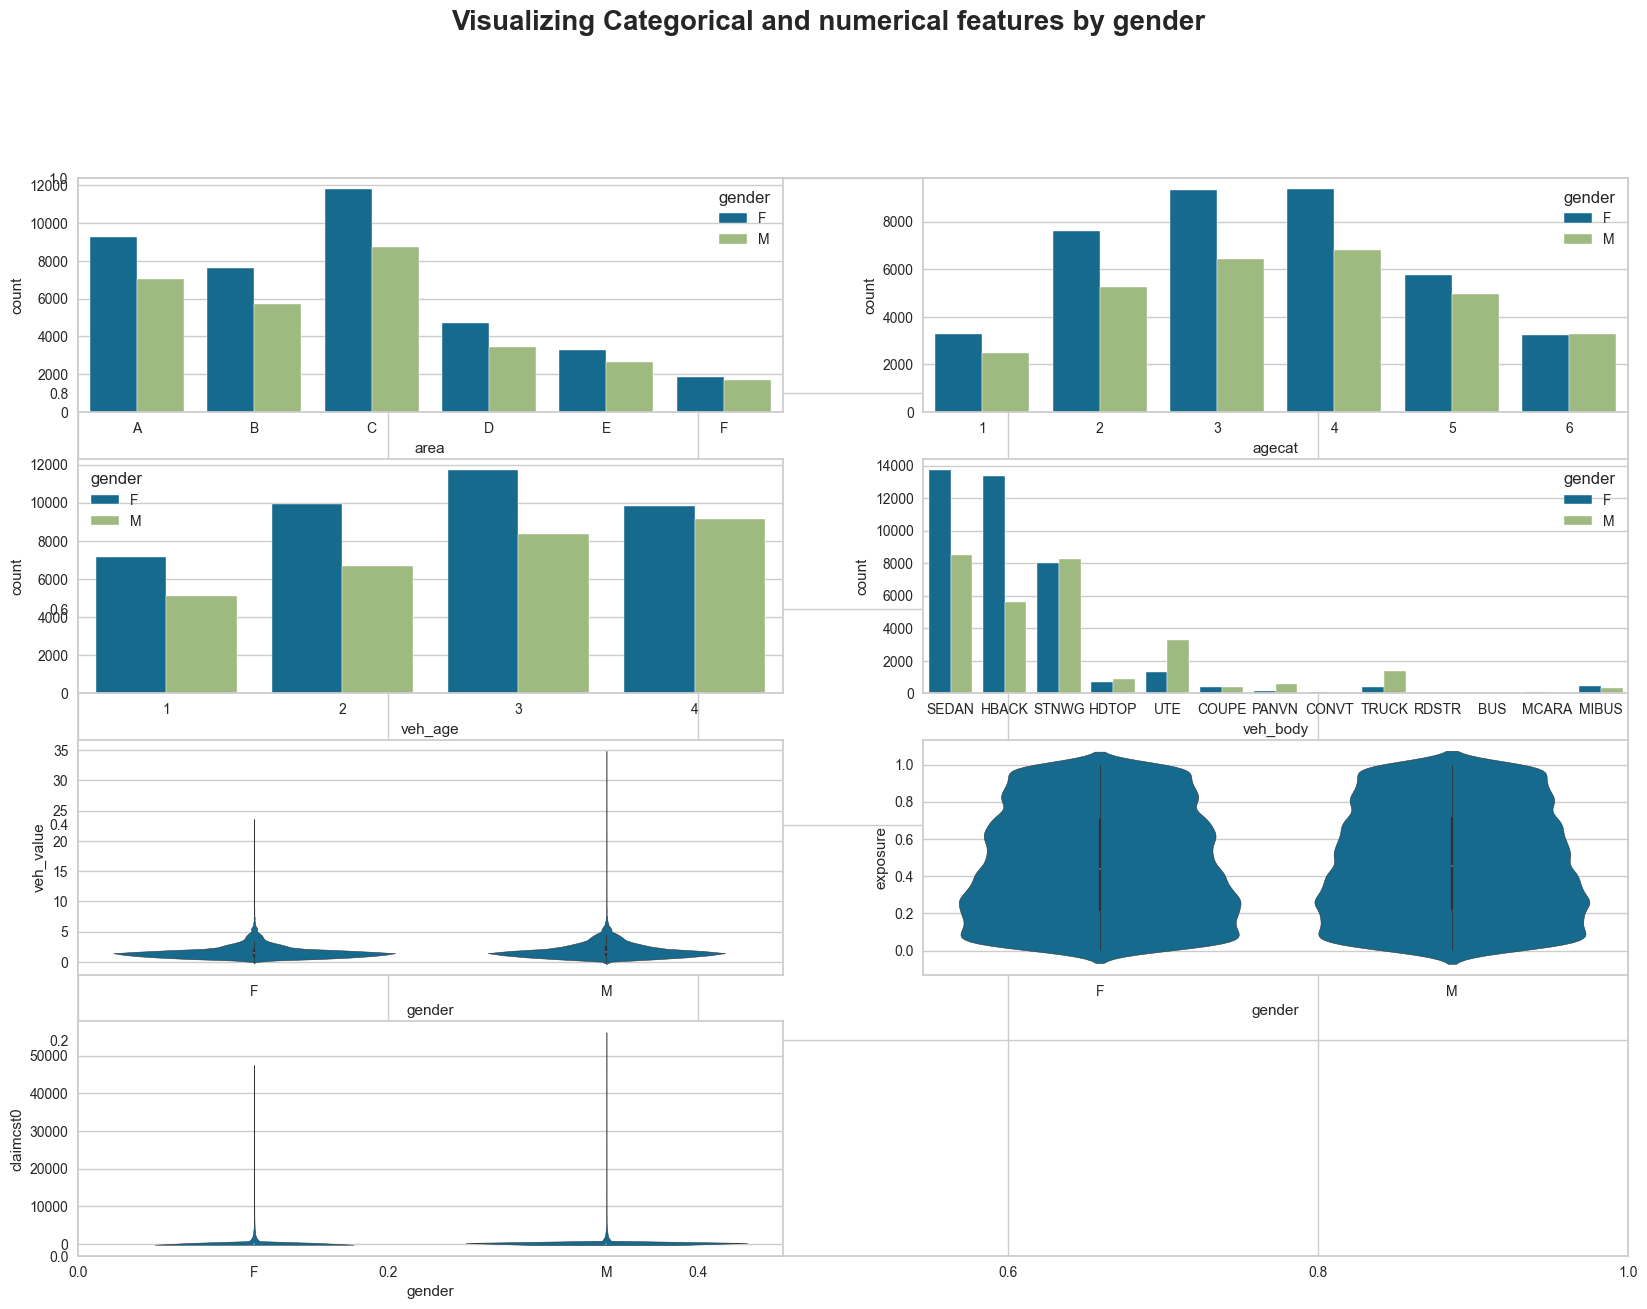

In [15]:
plt.subplots(figsize=(20,14))
plt.suptitle(f"Visualizing Categorical and numerical features by gender",fontsize=20,fontweight="bold",y=1.)
plt.subplot(421)
sns.countplot(x="area",hue="gender",data=df)
plt.subplot(422)
sns.countplot(x="agecat",hue="gender",data=df)
plt.subplot(423)
sns.countplot(x="veh_age",hue="gender",data=df)
plt.subplot(424)
sns.countplot(x="veh_body",hue="gender",data=df)
plt.subplot(425)
sns.violinplot(x="gender",y="veh_value",data=df)
plt.subplot(426)
sns.violinplot(x="gender",y="exposure",data=df)
plt.subplot(427)
sns.violinplot(x="gender",y="claimcst0",data=df)
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresbytargetGraphs/plot_features_by_gender.png',dpi=500);


---

In [16]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

*Define x and y*

In [17]:
x=df.drop("gender",axis=1)
y=df["gender"]

---

*Countinuous features Skewbess -outliers-*

In [18]:
x[countinuous_feature].skew(axis=0,skipna=True)

veh_value     2.968022
exposure      0.175557
claimcst0    17.502503
dtype: float64

---

*Transforming countinuous features to handle the outliers*

In [19]:
from sklearn.preprocessing import PowerTransformer
pt=PowerTransformer(method="yeo-johnson")
transform_features=['veh_value']
df[transform_features]=pt.fit_transform(x[transform_features])

In [20]:
df[transform_features].skew(axis=0,skipna=True)

veh_value    0.010369
dtype: float64

---

In [23]:
sc=StandardScaler()
preprocessor=ColumnTransformer([
    ("StandardScaler",sc,x.columns)
]
)

In [24]:
x=preprocessor.fit_transform(x)

---

*Hundling unbalanced data :*

In [25]:
from imblearn.combine import SMOTETomek,SMOTEENN
smt=SMOTEENN(random_state=42,sampling_strategy="minority")
x_re,y_res=smt.fit_resample(x,y)


---

*Split data into train and test subdata :*

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_re,y_res ,test_size= 0.2,random_state=42)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (16640, 7) and Y = (16640,) : 
Test data shape of X = (4161, 7) and Y = (4161,) : 


---

*Define models :*

In [27]:
models = {
        
        "XGBRFClassifier": XGBRFClassifier(),
        "GradientBoostingClassifier":GradientBoostingClassifier(),
        "RandomForestClassifier": RandomForestClassifier(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "LogisticRegression":LogisticRegression(),
        "SVC":SVC(),
        "KNeighborsClassifier":KNeighborsClassifier()
        
}

---

*Define evaluation funtion :*

In [28]:
def evaluation_preds_list(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    precision=precision_score(y_true,predicted)
    recall=recall_score(y_true,predicted)
    f1=f1_score(y_true,predicted)
    roc_auc=roc_auc_score(y_true,predicted)
    metrics_dict={
       "accuracy": round(accuracy,3),
        "precision": round(precision,3),
        "recall":round(recall,3),
        "f1":round(f1,3),
        "roc_auc":round(roc_auc,3)

    }
   
    return metrics_dict

In [29]:
def evaluation_preds(y_true,predicted):
    accuracy=accuracy_score(y_true,predicted)
    precision=precision_score(y_true,predicted)
    recall=recall_score(y_true,predicted)
    f1=f1_score(y_true,predicted)
    roc_auc=roc_auc_score(y_true,predicted)   
    return accuracy,precision,recall,f1,roc_auc

---

*Create one function to model the data :*

In [30]:
def evalua_models():
    models_list=[]
    accuracy_list=[]
    auc_list=[]
    pres_list=[]
    recall_list=[]
    fi_list=[]
    for i in  range(len(list(models))):
        model=list(models.values())[i]
        model.fit(x_train,y_train)

        train_predicted=model.predict(x_train)
        test_predicted=model.predict(x_test)      
        
        test_predicted_accuracy,test_predicted_precision,test_predicted_recall,\
        test_predicted_f1,test_predicted_roc_auc=evaluation_preds(y_test,test_predicted)
       
        accuracy_list.append(test_predicted_accuracy)
        pres_list.append(test_predicted_precision)
        recall_list.append(test_predicted_recall)
        fi_list.append(test_predicted_f1)
        auc_list.append(test_predicted_roc_auc)

        
        models_list.append(list(models.keys())[i])

    report=pd.DataFrame(list(zip(models_list,accuracy_list,pres_list,recall_list,fi_list,auc_list)),columns=["model","acc","precision","recall","f1","auc"]).sort_values(by="acc",ascending=False) 
    return report
  

---

*Apply Data Modeling*

In [31]:
base_models=evalua_models()
base_models

,model,acc,precision,recall,f1,auc
2,RandomForestClassifier,0.922615,0.930201,0.926058,0.928125,0.922319
4,DecisionTreeClassifier,0.867580,0.872799,0.883296,0.878016,0.866231
7,KNeighborsClassifier,0.863254,0.870469,0.877060,0.873752,0.862069
1,GradientBoostingClassifier,0.813506,0.844674,0.801782,0.822669,0.814513
0,XGBRFClassifier,0.806056,0.839792,0.791537,0.814951,0.807303
3,AdaBoostClassifier,0.804134,0.821493,0.813808,0.817633,0.803303
6,SVC,0.796683,0.824895,0.791091,0.807640,0.797164
5,LogisticRegression,0.744292,0.734791,0.823163,0.776471,0.737521


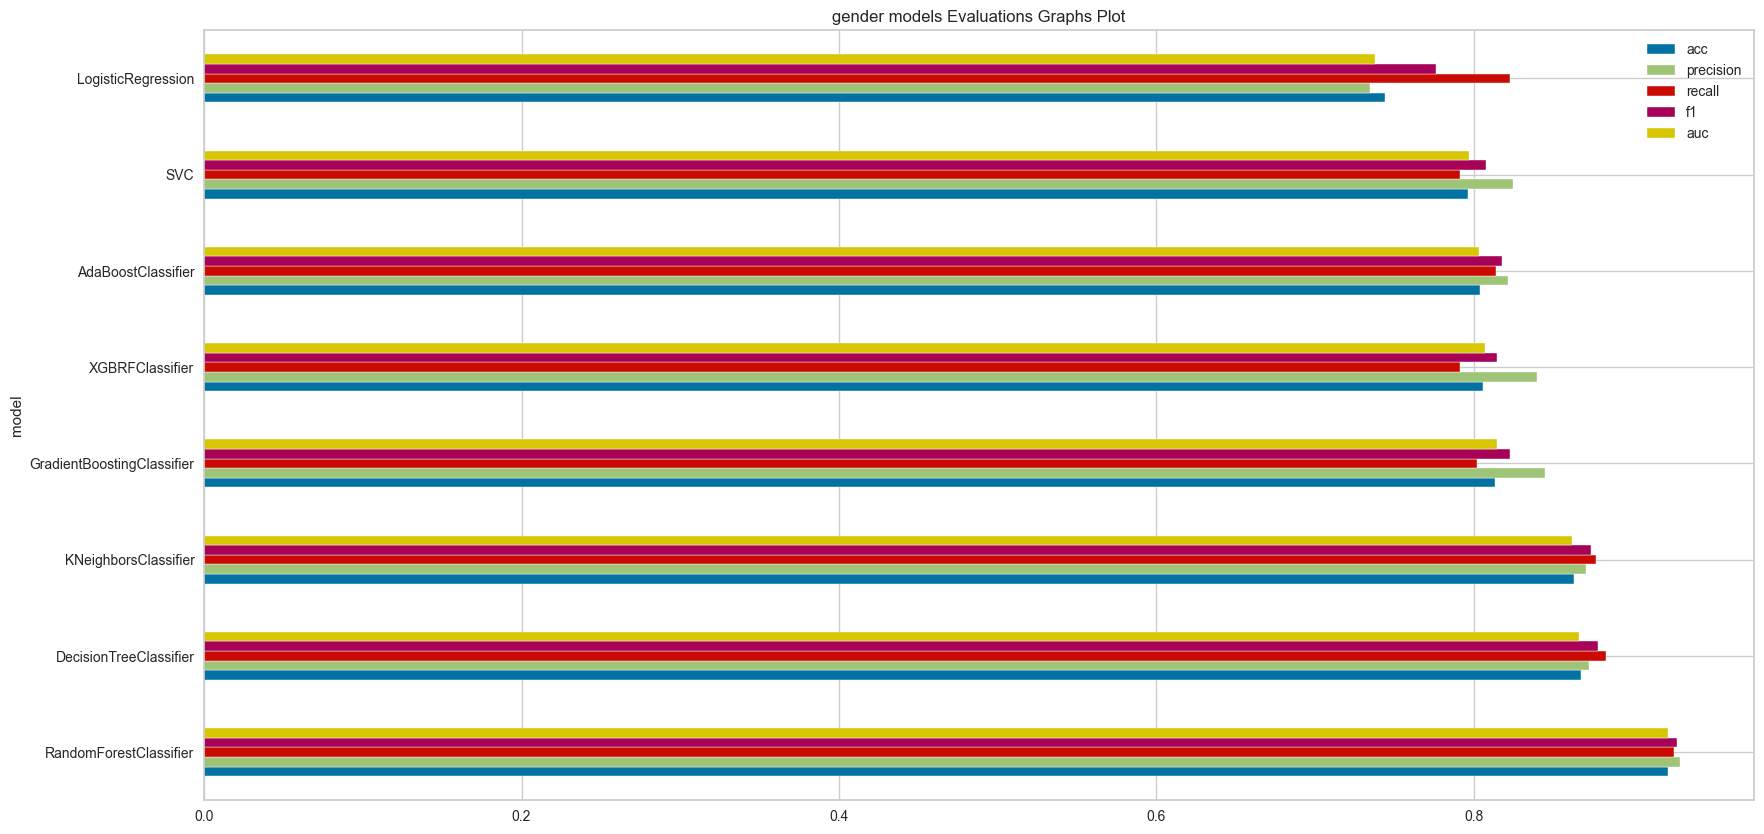

In [45]:
base_models.set_index("model").plot(kind="barh",figsize=(20,10),title="gender models Evaluations Graphs Plot");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/modelsEvaluationsGraphs/gender_EvaluationsGraph.png',dpi=500);

---

*Apply RandomForestClassifier :*

In [46]:
np.random.seed(42)
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
predicted=clf.predict(x_test)

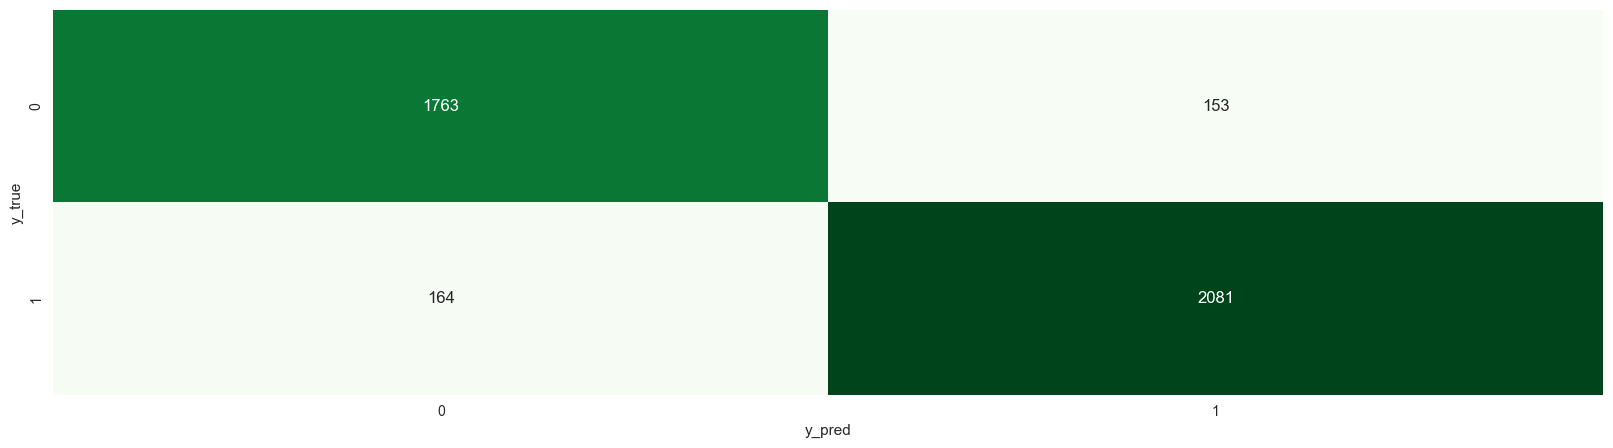

In [47]:
matplotlib.rcParams["figure.figsize"]=(20,5)
sns.heatmap(confusion_matrix(y_test,predicted),annot = True,cmap="Greens", fmt = ".0f",cbar=False)
plt.xlabel("y_pred")
plt.ylabel("y_true");
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/confusionMatrixGraphs/gender_confusion_matrixPlot.png',dpi=500);

In [48]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1916
           1       0.93      0.93      0.93      2245

    accuracy                           0.92      4161
   macro avg       0.92      0.92      0.92      4161
weighted avg       0.92      0.92      0.92      4161



---

*ROC curve :*

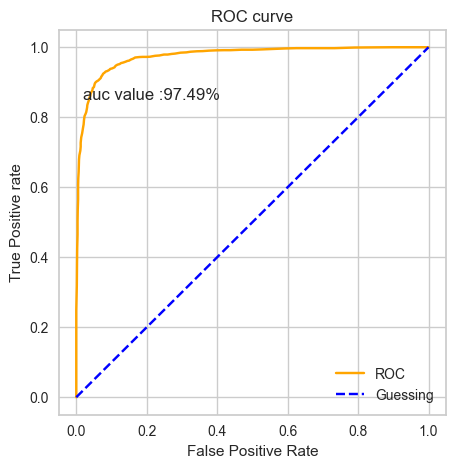

In [49]:
fpr,tpr,thresh=roc_curve(y_test,clf.predict_proba(x_test)[:,1])
AucValue=roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])
AucValue=f"{AucValue*100:.2f}%"
def plot_roc_curve(fpr,tpr):
    matplotlib.rcParams["figure.figsize"]=(5,5)
    plt.plot(fpr,tpr,color="orange",label="ROC")
    plt.plot([0,1],[0,1],color="blue",linestyle="--",label="Guessing")
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.text(0.02,0.85, f'auc value :{AucValue}')
    plt.legend()

plot_roc_curve(fpr,tpr);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/ROCcurveGraphs/gender_ROCcurveGraphs.png',dpi=500);    

In [51]:
clf.feature_names_in=list(df.drop("gender",axis=1).columns)
importance=pd.concat([pd.DataFrame(clf.feature_names_in,columns=["feature_names"]),
           pd.DataFrame(clf.feature_importances_,columns=["feature_importances"])],axis=1)
importance

,feature_names,feature_importances
0,veh_value,0.264541
1,exposure,0.202488
2,claimcst0,0.021252
3,veh_body,0.292949
4,veh_age,0.067069
5,area,0.067836
6,agecat,0.083865


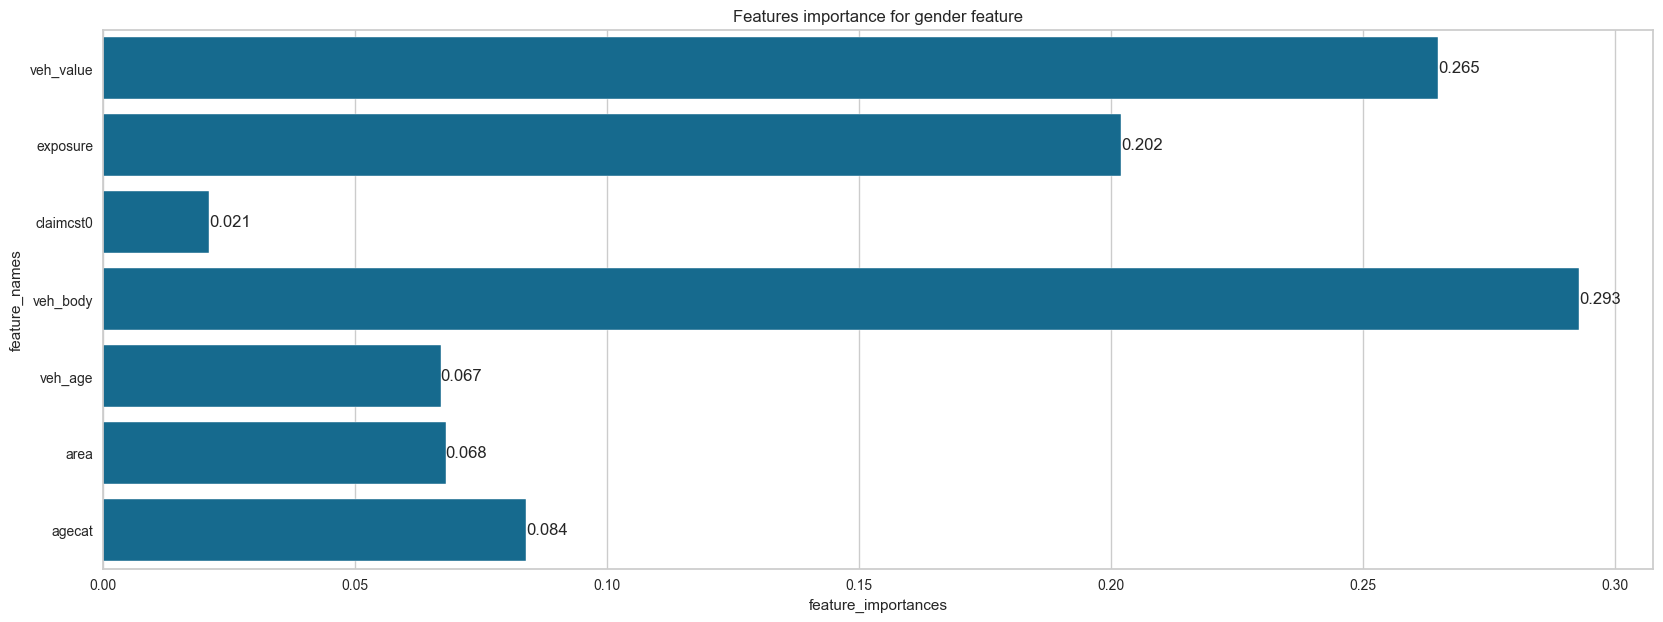

In [52]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for gender feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/featuresImportanceGraphs/gender_featureImportanc.png',dpi=500);

*Saving Best model :*

In [53]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/outcomes/bestModels/gender_prediction_model.pkl","wb") as f:
    pickle.dump(clf,f)

---